In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pyomo.environ as pyo
import numpy as np
from pyomo.opt import SolverFactory
from parser import parse_tsplib
from plotter import plot_tsp_solution, print_route_summary

opt = { # Please dont steal my credentials
    "WLSACCESSID": '60760e28-aa6e-4c6c-af3f-469592dc6bec',
    "WLSSECRET": '95fff45d-3d51-4958-b65c-7bbc487d2e09',
    "LICENSEID": 2707350,
}

# Problem 1

## Theory

The Traveling Salesman Problem (TSP), often expressed using the Miller–Tucker–Zemlin (MTZ) formulation, is a classic problem in optimization and graph theory. It aims to find the shortest possible route that visits each destination node exactly once and returns to the starting point (origin). In graph theory, this corresponds to a minimum-cost Hamiltonian cycle, which is a closed path that visits every vertex once. Such a cycle always exists if the network is complete, meaning every pair of nodes is linked by an edge.

The MTZ part is there to handle the elimination of subtours, it does this by introducing a new variable $u_i$ for each node we need to visit (excluding the origin) and this variable will corespond with the order we will visit the nodes. It is expressed as following:

$u_i - u_j + px_{i,j} \leq p-1 \quad (1 \leq i \neq j \leq n)$

This will thus eliminate all subtours because for a subtour to exist there need to exist a cycle from $x_{a,b},\ldots,x_{g,a}$ where all the $x$'s are 1 but this contradicts the increasing nature of the constraint. One could say that the MTZ forces the model to find a path between all the destination nodes. Notice that $p\cdot t \geq n$ this is to ensure the routes are long enough

The TSP can thus be formulated as following when $t=1$ else its a Vehicle Routing Problem (VRP)
$$
\min_{x} \sum_{i=0}^{n}\sum_{j=0,\\ i\neq j}^{n} c_{i,j} x_{i,j} \\
s.t \\
\sum_{i=0, i\neq j}^{n} x_{i,j} = 1 \quad (j = 1,\ldots,n) \quad \text{Inflow constraint} \\
\sum_{j=0, j\neq i}^{n} x_{i,j} = 1 \quad (i = 1,\ldots,n) \quad \text{Outflow constraint} \\
u_i - u_j + px_{i,j} \leq p-1 \quad (1 \leq i \neq j \leq n) \quad \text{MTZ subtour elimination}  \\
\sum_{i=1}^{n} x_{i,0} = t \quad \text{Inflow constraint from origin} \\
\sum_{j=1}^{n} x_{0,j} = t \quad \text{Outflow constraint from origin} \\
x_{i,j} \in \{0,1\} \quad \forall i,j\\
u_{j} \in Z^{+} \quad \forall j

$$
Observe I use 0 indexing to handle the origin, Assume aswell that there are no self loop and that we are working with the standard traveling salesman problem where we only allow one tour from the origin, $t=1$ and can thus let $p=n$.
$$
\min_{x} \sum_{i=0}^{n}\sum_{j=0,\\ i\neq j}^{n} c_{i,j} x_{i,j} \\
s.t \\
\sum_{i=0, i\neq j}^{n} x_{i,j} = 1 \quad (j = 0,\ldots,n) \quad \text{Inflow constraint} \\
\sum_{j=0, j\neq i}^{n} x_{i,j} = 1 \quad (i = 0,\ldots,n) \quad \text{Outflow constraint} \\
u_i - u_j + nx_{i,j} \leq n-1 \quad (1 \leq i \neq j \leq n) \quad \text{MTZ subtour elimination}\\
x_{i,j} \in \{0,1\} \quad \forall i,j\\
u_{j} \in Z^{+} \quad \forall j
$$

## Code

In [2]:
def build_tsp_mtz(dist) -> pyo.Model: # GPT-5 GENERATED with alot of modifications
    """
    Pyomo MTZ TSP model (depot = 0), with clean domains (no 'if' inside rules).
    Args:
        dist: square cost/distance matrix-like (n x n), index 0..n-1
    Returns:
        pyo.Model
    """
    n = len(dist)
    P = n  # MTZ constant

    m = pyo.ConcreteModel()

    # --- Sets (domains) ---
    m.V   = pyo.Set(initialize=range(n), ordered=True)                # all nodes {0..n-1}
    m.Vnd = pyo.Set(initialize=range(1, n), ordered=True)             # non-depot nodes {1..n-1}
    m.A   = pyo.Set(dimen=2, initialize=[(i, j) for i in range(n) for j in range(n) if i != j])
    # pairs used in MTZ (exclude depot and diagonals)
    m.MTZPairs = pyo.Set(dimen=2, initialize=[(i, j) for i in range(1, n) for j in range(1, n) if i != j])

    # --- Parameters ---
    def c_rule(m, i, j):
        return float(dist[i][j])
    m.c = pyo.Param(m.A, initialize=c_rule, within=pyo.NonNegativeReals, mutable=False)

    # --- Decision variables ---
    m.x = pyo.Var(m.A, within=pyo.Binary)   # arc selection
    m.u = pyo.Var(m.V, within=pyo.Reals)    # MTZ order variables

    # --- Objective ---
    m.obj = pyo.Objective(expr=sum(m.c[i, j] * m.x[i, j] for (i, j) in m.A), sense=pyo.minimize)

    # --- Degree constraints (enter once, leave once) ---
    m.outdeg = pyo.Constraint(m.V, rule=lambda m, i: sum(m.x[i, j] for j in m.V if j != i) == 1)
    m.indeg  = pyo.Constraint(m.V, rule=lambda m, j: sum(m.x[i, j] for i in m.V if i != j) == 1)

    # --- MTZ: fix depot and bound non-depot u's WITHOUT 'if' in rules --- # UNECESSARY GPT GENERATED 
    # Fix depot order
    #m.u[0].fix(1)
    # Bounds for non-depot nodes via constraints (instead of conditional bounds rule)
    #m.u_lb = pyo.Constraint(m.Vnd, rule=lambda m, i: m.u[i] >= 2)
    #m.u_ub = pyo.Constraint(m.Vnd, rule=lambda m, i: m.u[i] <= P)

    # MTZ subtour-elimination (domain already excludes depot and i==j)
    m.mtz = pyo.Constraint(m.MTZPairs, rule=lambda m, i, j: m.u[i] - m.u[j] + P * m.x[i, j] <= P - 1)

    # Optional Gurobi suffixes (import duals/reduced costs if needed)
    m.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    m.rc   = pyo.Suffix(direction=pyo.Suffix.IMPORT)

    return m




--- Solving TSP MTZ for berlin52.tsp ---

Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 300
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2690 v4 @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 28 logical processors, using up to 28 threads

Non-default parameters:
TimeLimit  300
QCPDual  1

Academic license 2707350 - for non-commercial use only - registered to an___@kth.se
Optimize a model with 2654 rows, 2704 columns and 12954 nonzeros
Model fingerprint: 0x45e165e9
Variable types: 52 continuous, 2652 integer (2652 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [2e+01, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 0 rows and 2 columns
Presolve time: 0.05s
Presolved: 2654 rows, 2702 columns, 12854 nonzeros
Variable types: 50 continuous, 2652 integer

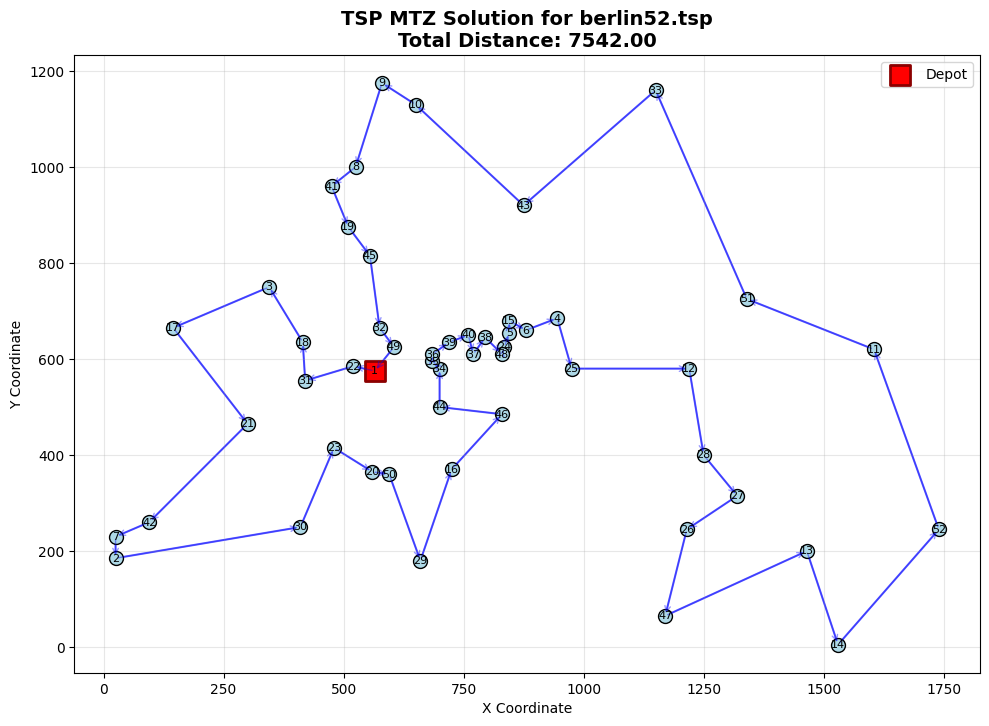

TSP Solution Summary: berlin52
Problem Dimension: 52 nodes
Total Distance: 7542.00

Route (visiting order):
1 -> 29 -> 22 -> 19 -> 49 -> 28 -> 15 -> 45 -> 43 -> 33 -> 34 -> 35 -> 38 -> 39 -> 36 -> 37 -> 47 -> 23 -> 4 -> 14 -> 5 -> 3 -> 24 -> 11 -> 27 -> 26 -> 25 -> 46 -> 12 -> 13 -> 51 -> 10 -> 50 -> 32 -> 42 -> 9 -> 8 -> 7 -> 40 -> 18 -> 44 -> 31 -> 48 -> 0 -> 21 -> 30 -> 17 -> 2 -> 16 -> 20 -> 41 -> 6 -> 1


--- Solving TSP MTZ for lin318.tsp ---

Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 300
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2690 v4 @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 28 logical processors, using up to 28 threads

Non-default parameters:
TimeLimit  300
QCPDual  1

Academic license 2707350 - for non-commercial use only - registered to an___@kth.se
Optimize a model with 100808 rows, 101124 columns and 50

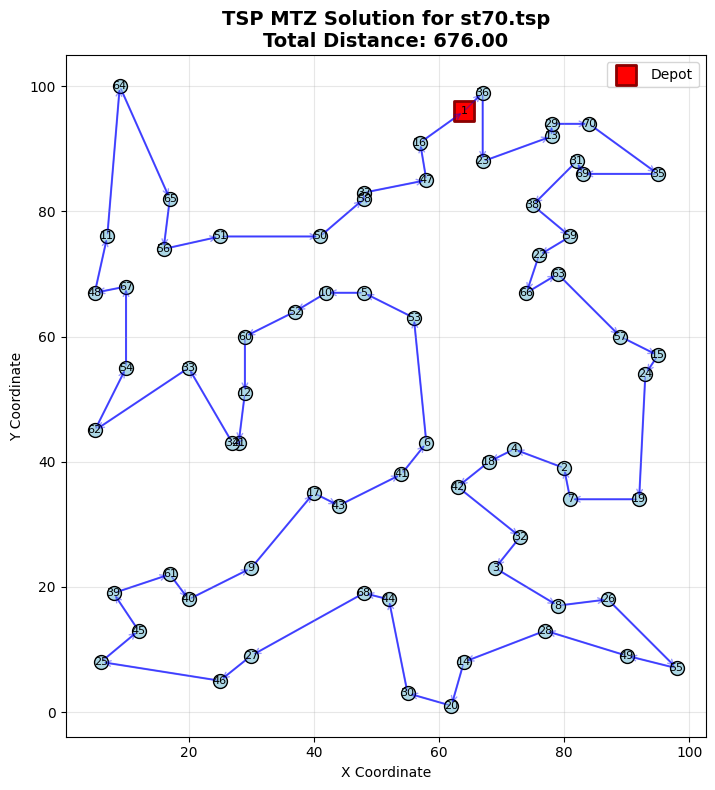

TSP Solution Summary: st70
Problem Dimension: 70 nodes
Total Distance: 676.00

Route (visiting order):
1 -> 3 -> 17 -> 41 -> 31 -> 2 -> 7 -> 25 -> 54 -> 48 -> 27 -> 13 -> 19 -> 29 -> 43 -> 67 -> 26 -> 45 -> 24 -> 44 -> 38 -> 60 -> 39 -> 8 -> 16 -> 42 -> 40 -> 5 -> 52 -> 4 -> 9 -> 51 -> 59 -> 11 -> 20 -> 33 -> 32 -> 61 -> 53 -> 66 -> 47 -> 10 -> 63 -> 64 -> 55 -> 50 -> 49 -> 57 -> 36 -> 46 -> 15 -> 0 -> 35 -> 22 -> 12 -> 28 -> 69 -> 34 -> 68 -> 30 -> 37 -> 58 -> 21 -> 65 -> 62 -> 56 -> 14 -> 23 -> 18 -> 6 -> 1


--- Solving TSP MTZ for ts225.tsp ---

Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 300
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2690 v4 @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 28 logical processors, using up to 28 threads

Non-default parameters:
TimeLimit  300
QCPDual  1

Academic license 2707350 - for non-com

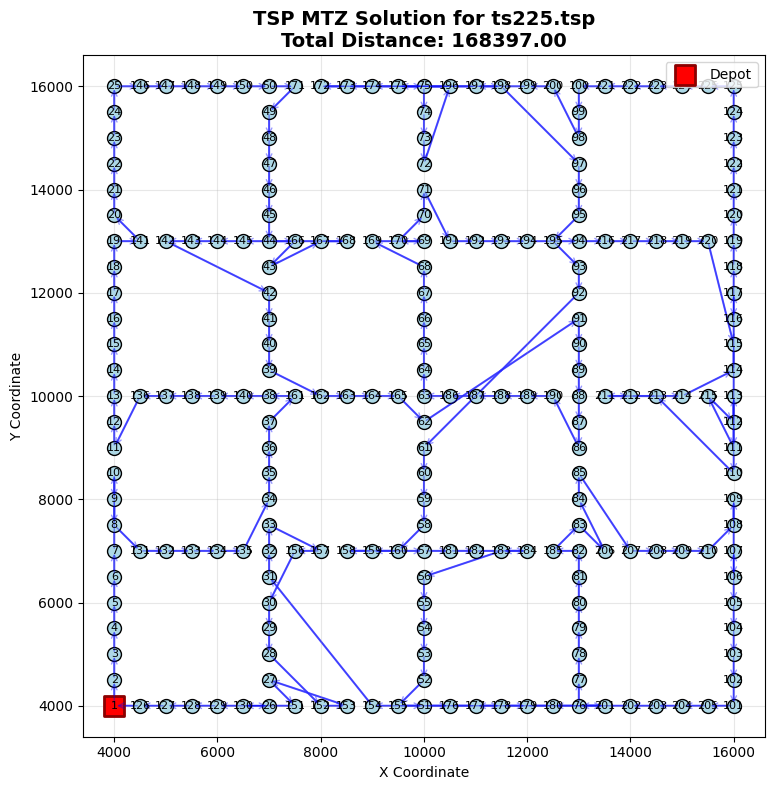

TSP Solution Summary: ts225
Problem Dimension: 225 nodes
Total Distance: 168397.00

Route (visiting order):
1 -> 2 -> 3 -> 4 -> 5 -> 6 -> 9 -> 8 -> 7 -> 130 -> 131 -> 132 -> 133 -> 134 -> 33 -> 34 -> 35 -> 36 -> 160 -> 37 -> 139 -> 138 -> 137 -> 136 -> 135 -> 10 -> 11 -> 12 -> 13 -> 14 -> 15 -> 16 -> 17 -> 18 -> 140 -> 19 -> 20 -> 21 -> 22 -> 23 -> 24 -> 145 -> 146 -> 147 -> 148 -> 149 -> 49 -> 170 -> 48 -> 47 -> 46 -> 45 -> 44 -> 43 -> 165 -> 42 -> 166 -> 167 -> 144 -> 143 -> 142 -> 141 -> 41 -> 40 -> 39 -> 38 -> 161 -> 162 -> 163 -> 164 -> 61 -> 90 -> 89 -> 88 -> 87 -> 86 -> 85 -> 189 -> 188 -> 187 -> 186 -> 185 -> 62 -> 63 -> 64 -> 65 -> 66 -> 67 -> 168 -> 68 -> 169 -> 69 -> 70 -> 190 -> 191 -> 192 -> 193 -> 93 -> 215 -> 216 -> 217 -> 218 -> 219 -> 114 -> 110 -> 214 -> 111 -> 112 -> 109 -> 212 -> 210 -> 211 -> 213 -> 113 -> 116 -> 115 -> 117 -> 118 -> 119 -> 120 -> 121 -> 122 -> 123 -> 124 -> 224 -> 223 -> 222 -> 221 -> 220 -> 99 -> 98 -> 97 -> 199 -> 198 -> 196 -> 174 -> 74 -> 73 -

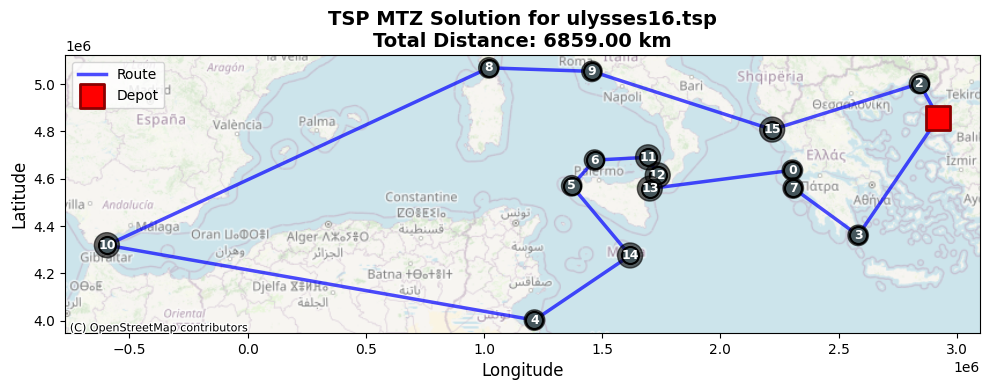

TSP Solution Summary: ulysses16.tsp
Problem Dimension: 16 nodes
Total Distance: 6859.00

Route (visiting order):
1 -> 2 -> 15 -> 9 -> 8 -> 10 -> 4 -> 14 -> 5 -> 6 -> 11 -> 12 -> 13 -> 0 -> 7 -> 3 -> 1


--- Solving TSP MTZ for ulysses22.tsp ---

Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 300
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2690 v4 @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 28 logical processors, using up to 28 threads

Non-default parameters:
TimeLimit  300
QCPDual  1

Academic license 2707350 - for non-commercial use only - registered to an___@kth.se
Optimize a model with 464 rows, 484 columns and 2184 nonzeros
Model fingerprint: 0xb9a428f1
Variable types: 22 continuous, 462 integer (462 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+01, 3e+03]
  Bounds range     [1e+0

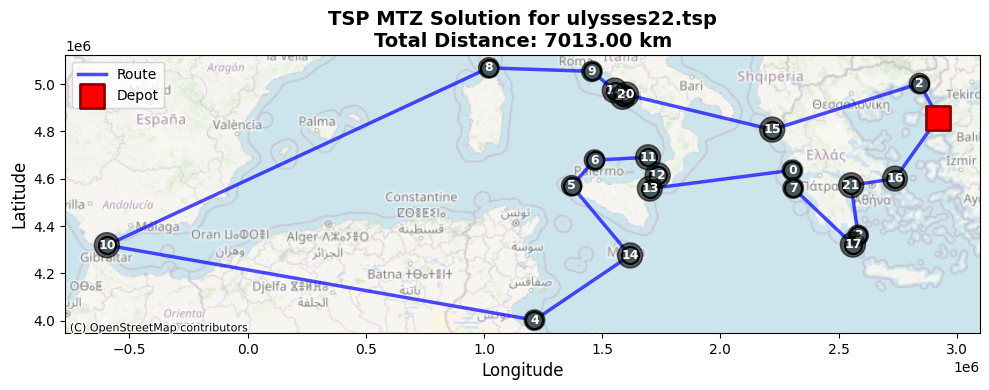

TSP Solution Summary: ulysses22.tsp
Problem Dimension: 22 nodes
Total Distance: 7013.00

Route (visiting order):
1 -> 2 -> 15 -> 20 -> 19 -> 18 -> 9 -> 8 -> 10 -> 4 -> 14 -> 5 -> 6 -> 11 -> 12 -> 13 -> 0 -> 7 -> 17 -> 3 -> 21 -> 16 -> 1


In [3]:
for problem in ['berlin52.tsp', 'lin318.tsp', 'st70.tsp', 'ts225.tsp', 'ulysses16.tsp', 'ulysses22.tsp']:
    try:
        print(f'\n\n--- Solving TSP MTZ for {problem} ---\n')
        data = parse_tsplib(f'Core/{problem}', build_dist=True) # Data parsing
        
        model = build_tsp_mtz(data['dist']) # Model building

        with SolverFactory( # Model Solving
        'gurobi_direct', solver_io='python', manage_env=True, options=opt
        ) as solver:
            solver.solve(
                model,
                tee=True,
                options={ # GPT RECOMMENDED with modifications
                    "TimeLimit": 300,       # Shorter time cap for testing (adjust as needed)
                    #"MIPFocus": 1,          # Focus on finding feasible solutions quickly
                    #"Heuristics": 0.25,     # Enable aggressive heuristics
                    #"Presolve": 2,          # Aggressive presolve
                    #"Cuts": 2,              # Apply strong cutting planes
                    #"Symmetry": 2,          # Exploit symmetry aggressively
                    #"Method": 1,            # Dual simplex — often fastest for TSP-like models
                    #"Crossover": 0,         # Disable crossover (since we don’t need interior solution)
                    #"Threads": 0,           # Use all available cores
                    #"NodefileStart": 0.5,   # Start writing node files to disk after 0.5 GB RAM
                    #"ConcurrentMIP": 2,  # Run two parallel MIP strategies
                    #"LazyConstraints": 0,   # Disable lazy constraint mode if not used
                }
            )
            
            plot_tsp_solution(data, model, title=f'TSP MTZ Solution for {problem}', start_node=1) # Plotting
            print_route_summary(data, model, start_node=1) # Route summary
    except Exception as e:
        print(f"Error occurred while processing {problem}: {e}")